In [1]:
# Recall @ false positive numbers

In [2]:
import pandas as pd
import seaborn as sns
from cucim import CuImage
from itertools import repeat
import multiprocessing as mp
import numpy as np
import nibabel as nb
import cv2
from skimage import io, color

In [3]:
def eval_10cases(results_folder, threshold_ = 0):

    F_measures = []
    Recalls = []
    Precisions = []

    Recalls_curves = []
    FPs_curves = []
    for slideindex in list(test_imglist):
        slideID = slideindex.split('/')[-1].split('.')[0]

        # load
        # cells_x_pred
        # cells_y_pred
        # prob_pred
        filename = slideID + '.txt'
        f = pd.read_csv(results_folder + filename,  header = None)
        # get the predictions
        cells_x_pred_read = f[0].tolist()
        cells_y_pred_read = f[1].tolist()
        prob_pred_read = f[2].tolist()
        
        # TODO: filter the results based on the contour masks
        maskpath = '/well/win-fmrib-analysis/users/gqu790/cell_segment/thumb_s/'
        maskfile = maskpath + slideID + '_contour.png'
        chartregions = io.imread(maskfile).T
        cells_x_pred = []
        cells_y_pred = []
        prob_pred = []
        
        for (cell_x_pred, cell_y_pred, prob_predict) in zip(cells_x_pred_read, cells_y_pred_read, prob_pred_read):
            if chartregions[np.int64(cell_x_pred / 2 ** 6-1), np.int64(cell_y_pred / 2 ** 6)-1] > 0:
                cells_x_pred.append(cell_x_pred)
                cells_y_pred.append(cell_y_pred)
                prob_pred.append(prob_predict)

        # get the GT
        mpp = slideread['mpp'][np.where(slideread['slide_id'] == slideID)[0][0]]
        cellx_GT = []
        celly_GT = []
        for cellid, xcor, ycor in zip(cellread.slide_id, cellread.cell_x, cellread.cell_y):
            if cellid == slideID:
                cellx_GT.append(xcor / mpp)
                celly_GT.append(ycor / mpp)

#         threshold = 0.
        preds = np.where(np.array(prob_pred) > threshold_)
        cells_x_pred_threshold = []
        cells_y_pred_threshold = []
        for pred_point in preds[0]:
            cells_x_pred_threshold.append(cells_x_pred[pred_point])
            cells_y_pred_threshold.append(cells_y_pred[pred_point])

        TP = 0
        dist_hist = 30
        
        for (cell_x_pred_c, cell_y_pred_c) in zip(cells_x_pred_threshold, cells_y_pred_threshold):
            for (cell_x_GT_c, cell_y_GT_c) in zip(cellx_GT, celly_GT):
                if np.linalg.norm(np.array((cell_x_GT_c,cell_y_GT_c))-np.array((cell_x_pred_c,cell_y_pred_c))) < dist_hist:
                    TP = TP + 1
        #             print('hit!')
                    break
        #     print(cell_x_GT_c)
        
        if len(cells_x_pred_threshold) > 0:
            F_measure = 2 * TP / (len(cellx_GT) + len(cells_x_pred_threshold))
            Recall = TP / len(cellx_GT)
            Precision = TP / len(cells_x_pred_threshold)
        else:
            F_measure = 0
            Recall = 0
            Precision = 0
        
        F_measures.append(F_measure)
        Recalls.append(Recall)
        Precisions.append(Precision)

        thresholds = list(range(0,100,2))
        Recalls_curve = []
        FPs = []
        for thrshold100 in thresholds:
            threshold = thrshold100 / 100
            preds = np.where(np.array(prob_pred) > threshold)
            cells_x_pred_threshold = []
            cells_y_pred_threshold = []
            for pred_point in preds[0]:
                cells_x_pred_threshold.append(cells_x_pred[pred_point])
                cells_y_pred_threshold.append(cells_y_pred[pred_point])

            TP = 0
            dist_hist = 30

            for (cell_x_pred_c, cell_y_pred_c) in zip(cells_x_pred_threshold, cells_y_pred_threshold):
                for (cell_x_GT_c, cell_y_GT_c) in zip(cellx_GT, celly_GT):               
                    if np.linalg.norm(np.array((cell_x_GT_c,cell_y_GT_c))-np.array((cell_x_pred_c,cell_y_pred_c))) < dist_hist:
                        TP = TP + 1
                        break
            Recalls_curve.append(TP / len(cellx_GT))
            FPs.append(len(cells_x_pred_threshold) - TP)
        #     print(threshold)

        Recalls_curves.append(Recalls_curve)
        FPs_curves.append(FPs)

        print('processed ' + slideindex)

    return F_measures, Recalls, Precisions, Recalls_curves, FPs_curves

In [4]:
# results txt files
cellpath = '/well/win-fmrib-analysis/projects/win-mac-histo/hand_labelled/cells_database/cells.csv'
slidepath = '/well/win-fmrib-analysis/projects/win-mac-histo/hand_labelled/cells_database/slides.csv'
cellread = pd.read_csv(cellpath) # Sean's file
slideread = pd.read_csv(slidepath) # Sean's file
droplist = []
ID = 0
for cslide in slideread['slide_id']:
    if cslide not in list(cellread['slide_id']):
        droplist.append(ID)
    ID = ID + 1
slideread_refined = slideread.drop(droplist)

In [5]:
imglist = list(slideread_refined.image.str.replace('.jp2', '.tif', regex=False).str.replace('_jp2', '_q90_tif'))
imglist_correct_res = imglist[:62]
import random
from random import shuffle
random.seed(0)
np.random.seed(0)
shuffle(imglist_correct_res)
# get about 20,000 images for training
test_imglist = imglist_correct_res[28:]

In [6]:
test_imglist

['mf179FR_c18/mf179FR_c18_q90_tif/mf179FR_c18_s20n.tif',
 'mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s17n.tif',
 'mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s06n.tif',
 'mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s08n.tif',
 'mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s13n.tif',
 'mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s18n.tif',
 'mr257FR_c04/mr257FR_c04_q90_tif/mr257FR_c04_s30n.tif',
 'mr257FR_c04/mr257FR_c04_q90_tif/mr257FR_c04_s18n.tif',
 'mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s04n.tif',
 'mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s03n.tif']

In [7]:
#
results_folder_model0_R20_ep500_wce100_t628 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model0_500ep_t628/'
results_folder_model0_R20_ep500_wce100_t314 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model0_500ep_t314/'
results_folder_model0_R20_ep500_wce100_t100 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model0_500ep_t100/'
results_folder_model0_R20_ep500_wce100_t10 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model0_500ep_t10/'
results_folder_model0_R20_ep500_wce500_t628 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model0_500ep_wce500_t628/'
results_folder_model0_R20_ep500_wce1000_t628 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model0_500ep_wce1000_t628/'
#
results_folder_model1_R20_ep500_wce10_t628 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model1_500ep_t628_wce10/'
results_folder_model1_R20_ep500_wce100_t628 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model1_500ep_t628/'
results_folder_model1_R20_ep500_wce100_t1256 = '/well/win-fmrib-analysis/users/gqu790/cell_segment/pred_model1_500ep_t1256/'

In [8]:
results_m0_wce500_t628 = eval_10cases(results_folder_model0_R20_ep500_wce500_t628)
results_m0_wce1000_t628 = eval_10cases(results_folder_model0_R20_ep500_wce1000_t628)
results_m0_t628 = eval_10cases(results_folder_model0_R20_ep500_wce100_t628)
results_m0_t10 = eval_10cases(results_folder_model0_R20_ep500_wce100_t10)
results_m1_t628_wce10 = eval_10cases(results_folder_model1_R20_ep500_wce10_t628)
results_m1_t628 = eval_10cases(results_folder_model1_R20_ep500_wce100_t628)

processed mf179FR_c18/mf179FR_c18_q90_tif/mf179FR_c18_s20n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s17n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s06n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s08n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s13n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s18n.tif
processed mr257FR_c04/mr257FR_c04_q90_tif/mr257FR_c04_s30n.tif
processed mr257FR_c04/mr257FR_c04_q90_tif/mr257FR_c04_s18n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s04n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s03n.tif
processed mf179FR_c18/mf179FR_c18_q90_tif/mf179FR_c18_s20n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s17n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s06n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s08n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s13n.tif
processed mr273FS_c03/mr273FS_c03_q90_tif/mr273FS_c03_s

In [9]:
print('F1 Score:')
print(f"U-Net results {np.mean(results_m0_t628[0])}")
print(f"U-Net results {np.mean(results_m0_wce500_t628[0])}")
print(f"U-Net results {np.mean(results_m0_wce1000_t628[0])}")
print(f"U-Net results t10 {np.mean(results_m0_t10[0])}")
print(f"Segformer results wce10 {np.mean(results_m1_t628_wce10[0])}")
print(f"Segformer results {np.mean(results_m1_t628[0])}")

F1 Score:
U-Net results 0.5438400772523176
U-Net results 0.5454071944871911
U-Net results 0.4446489155947212
U-Net results t10 0.48027197927048204
Segformer results wce10 0.31758002491335613
Segformer results 0.3419227277511783


In [10]:
print('Recall:')
print(f"U-Net results {np.mean(results_m0_wce500_t628[1])}")
print(f"U-Net results {np.mean(results_m0_wce1000_t628[1])}")
print(f"U-Net results {np.mean(results_m0_t628[1])}")
print(f"U-Net results t10 {np.mean(results_m0_t10[1])}")
#
print(f"Segformer results wce10 {np.mean(results_m1_t628_wce10[1])}")
print(f"Segformer results {np.mean(results_m1_t628[1])}")

Recall:
U-Net results 0.6766587369225713
U-Net results 0.7070316930378493
U-Net results 0.5428919551180122
U-Net results t10 0.625478503745464
Segformer results wce10 0.5267708157461973
Segformer results 0.8665393718879469


<AxesSubplot:>

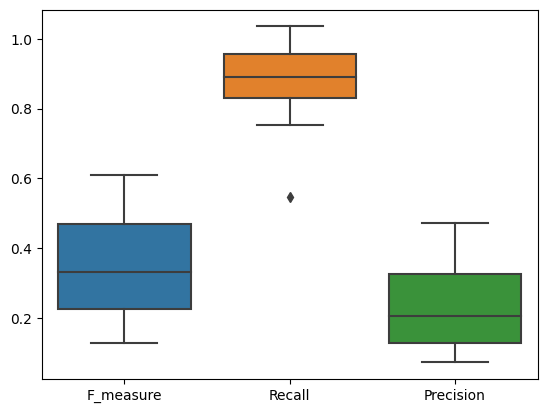

In [11]:
data_plot = pd.DataFrame({"F_measure":results_m1_t628[0], "Recall":results_m1_t628[1], "Precision":results_m1_t628[2]})
sns.boxplot(data_plot)

In [12]:
Recalls_curve_mean_0_w500 = np.mean(np.array(results_m0_wce500_t628[3][:7]), axis=0)
FPs_curves_mean_0_w500 = np.mean(np.array(results_m0_wce500_t628[4][:7]), axis=0)

Recalls_curve_mean_0_w1000 = np.mean(np.array(results_m0_wce1000_t628[3][:7]), axis=0)
FPs_curves_mean_0_w1000 = np.mean(np.array(results_m0_wce1000_t628[4][:7]), axis=0)


Recalls_curve_mean_0 = np.mean(np.array(results_m0_t628[3][:7]), axis=0)
FPs_curves_mean_0 = np.mean(np.array(results_m0_t628[4][:7]), axis=0)

Recalls_curve_mean_0_t10 = np.mean(np.array(results_m0_t10[3][:7]), axis=0)
FPs_curves_mean_0_t10 = np.mean(np.array(results_m0_t10[4][:7]), axis=0)

Recalls_curve_mean_1_wce10 = np.mean(np.array(results_m1_t628_wce10[3][:7]), axis=0)
FPs_curves_mean_1_wce10 = np.mean(np.array(results_m1_t628_wce10[4][:7]), axis=0)

Recalls_curve_mean_1 = np.mean(np.array(results_m1_t628[3][:7]), axis=0)
FPs_curves_mean_1 = np.mean(np.array(results_m1_t628[4][:7]), axis=0)

(0.0, 1.0)

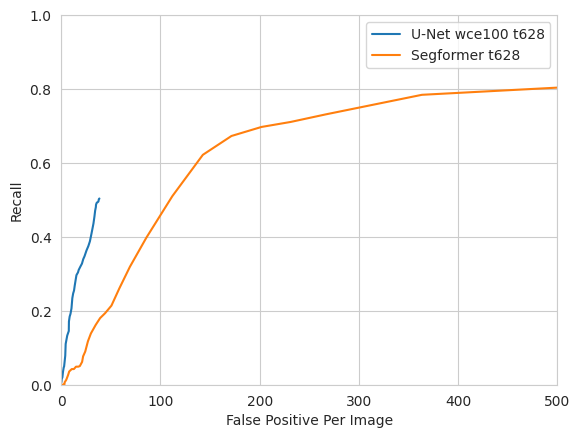

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_0, "False Positive Per Image":FPs_curves_mean_0})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "U-Net wce100 t628")

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_1, "False Positive Per Image":FPs_curves_mean_1})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "Segformer t628")


plt.xlim([0, 500])
plt.ylim([0, 1])

(0.0, 1.0)

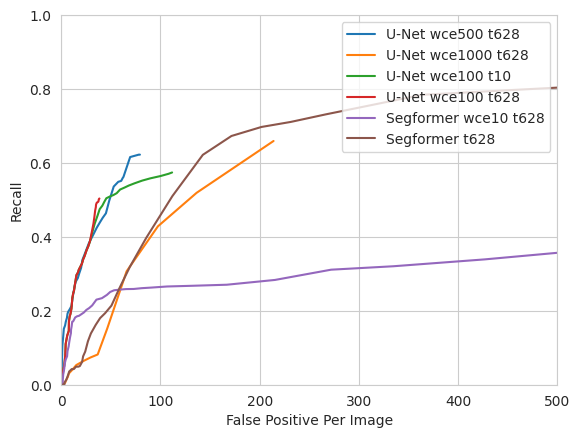

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_0_w500, "False Positive Per Image":FPs_curves_mean_0_w500})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "U-Net wce500 t628")

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_0_w1000, "False Positive Per Image":FPs_curves_mean_0_w1000})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "U-Net wce1000 t628")

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_0_t10, "False Positive Per Image":FPs_curves_mean_0_t10})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "U-Net wce100 t10")

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_0, "False Positive Per Image":FPs_curves_mean_0})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "U-Net wce100 t628")

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_1_wce10, "False Positive Per Image":FPs_curves_mean_1_wce10})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "Segformer wce10 t628")

data_plot = pd.DataFrame({"Recall":Recalls_curve_mean_1, "False Positive Per Image":FPs_curves_mean_1})
sns.set_style("whitegrid")
sns.lineplot(x = "False Positive Per Image", y = "Recall", data=data_plot, label = "Segformer t628")


plt.xlim([0, 500])
plt.ylim([0, 1])

In [14]:
# OK, the threshold of region area does not matter.. that much
# If we want to clean the prediction, we should make decision based on probability